# Importing Libraries

In [1]:
!pip install -Uq watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.31.1

numpy : 1.20.2
pandas: 1.3.5
torch : 1.12.0



In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Loading Dataset

In [4]:
# Loading Dataset
df = pd.read_csv ('./time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/15/22,11/16/22,11/17/22,11/18/22,11/19/22,11/20/22,11/21/22,11/22/22,11/23/22,11/24/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,204724,204820,204982,205009,205039,205146,205229,205324,205391,205506
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,333197,333215,333233,333233,333246,333256,333257,333282,333293,333305
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,270969,270981,270996,270996,271011,271023,271028,271035,271041,271050
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,46664,46824,46824,46824,46824,46824,46824,46824,46824,46824
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,104491,104491


In [5]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/15/22,11/16/22,11/17/22,11/18/22,11/19/22,11/20/22,11/21/22,11/22/22,11/23/22,11/24/22
0,0,0,0,0,0,0,0,0,0,0,...,204724,204820,204982,205009,205039,205146,205229,205324,205391,205506
1,0,0,0,0,0,0,0,0,0,0,...,333197,333215,333233,333233,333246,333256,333257,333282,333293,333305
2,0,0,0,0,0,0,0,0,0,0,...,270969,270981,270996,270996,271011,271023,271028,271035,271041,271050
3,0,0,0,0,0,0,0,0,0,0,...,46664,46824,46824,46824,46824,46824,46824,46824,46824,46824
4,0,0,0,0,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,104491,104491


In [6]:
df.isnull().sum().sum()

0

In [7]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
dtype: int64

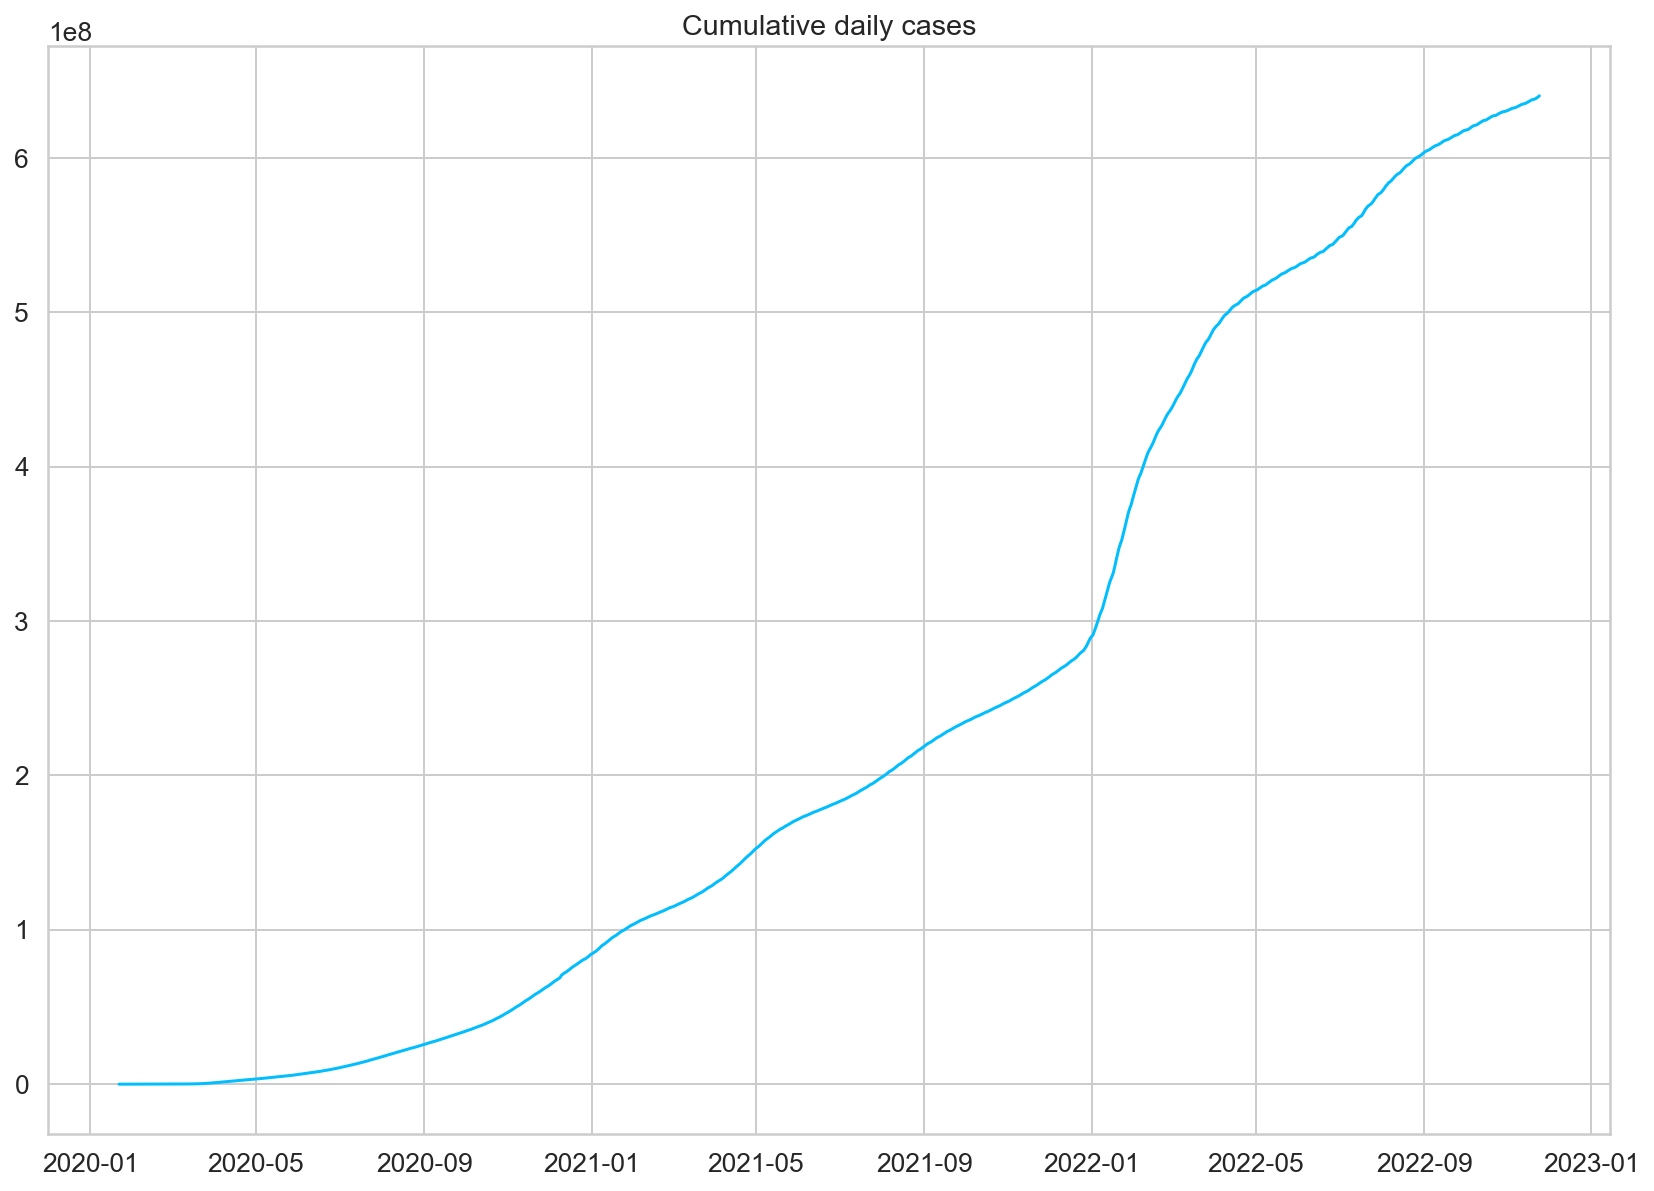

In [8]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [9]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23    100
2020-01-24    287
2020-01-25    493
2020-01-26    683
dtype: int64

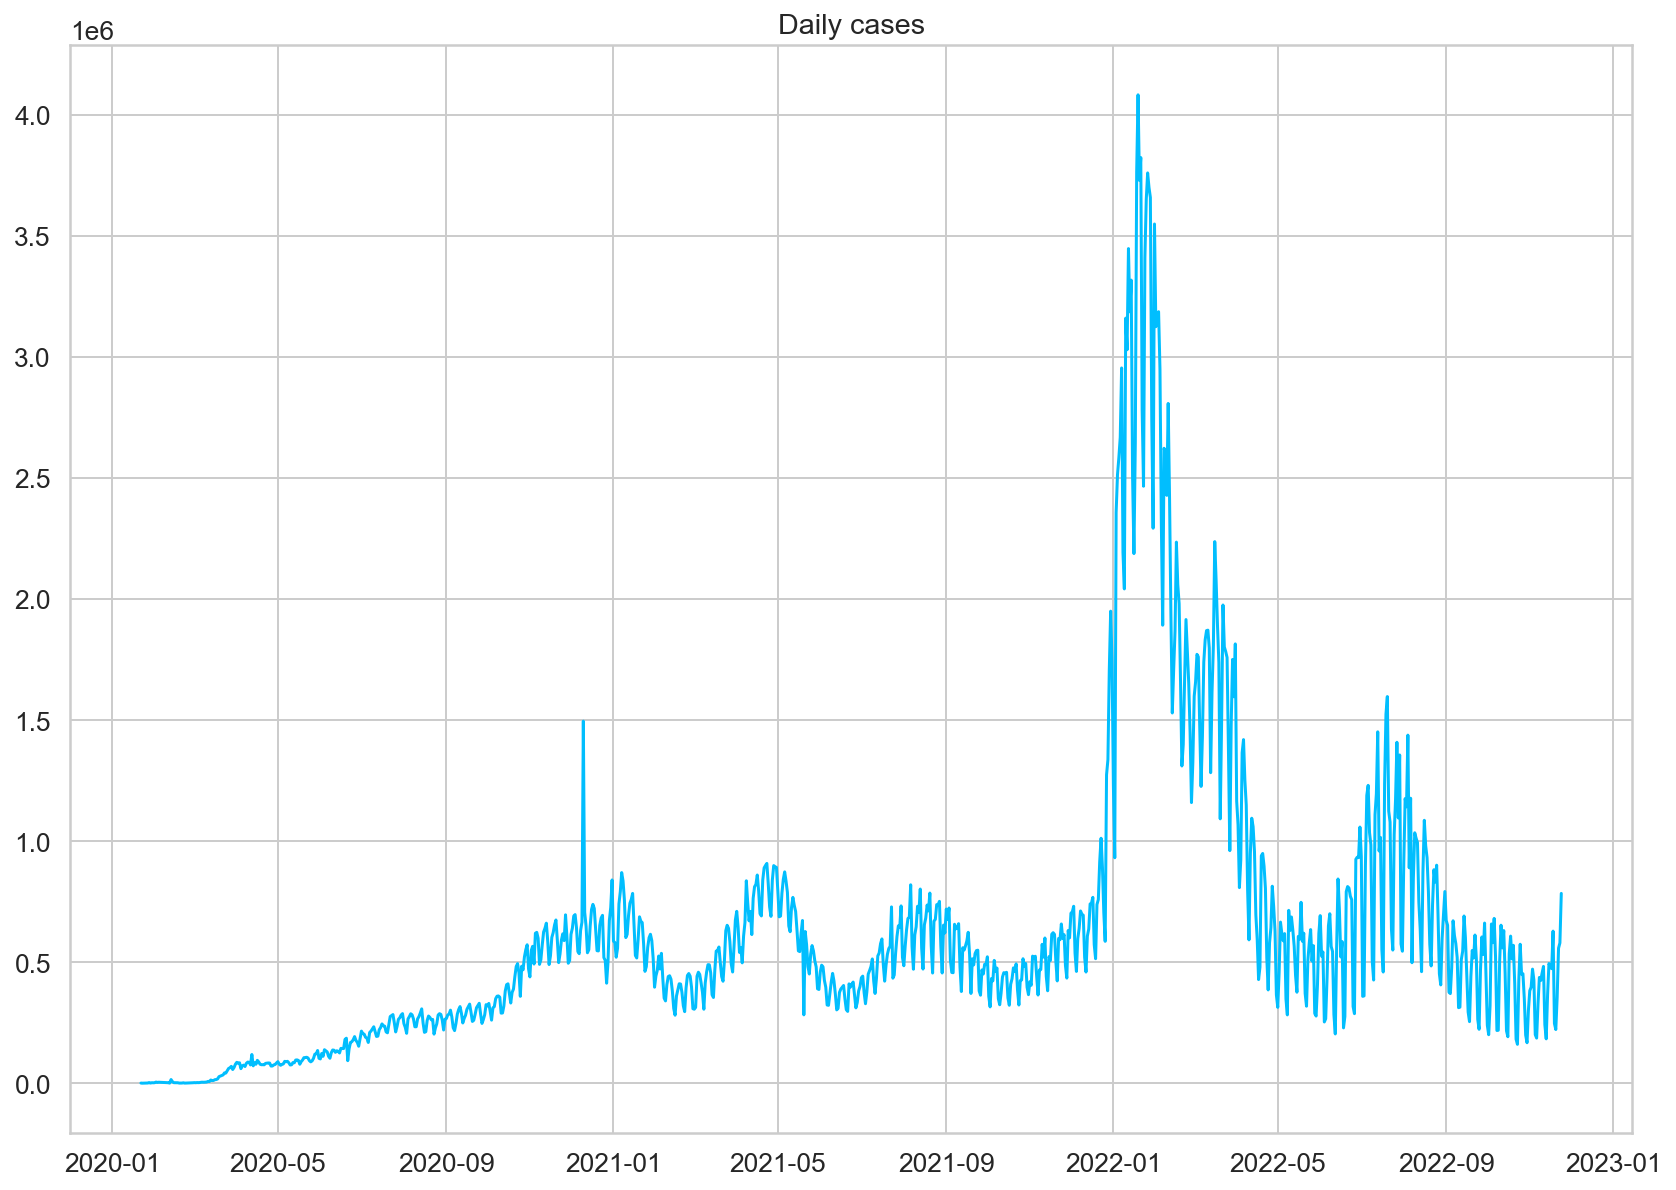

In [10]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [11]:
daily_cases.shape

(1038,)

# Preprocessing

In [12]:
# Using 260 days for testing and rest for training
test_data_size = 260

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape


(778,)

In [13]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [14]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [15]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
X_train.shape

torch.Size([772, 5, 1])

In [17]:
X_train[:2]

tensor([[[1.1195e-04],
         [0.0000e+00],
         [4.5808e-05],
         [9.6270e-05],
         [1.4281e-04]],

        [[0.0000e+00],
         [4.5808e-05],
         [9.6270e-05],
         [1.4281e-04],
         [1.7368e-04]]])

In [18]:
y_train.shape

torch.Size([772, 1])

In [19]:
y_train[:2]

tensor([[0.0002],
        [0.0006]])

In [20]:
train_data[:10]

array([[1.11947876e-04],
       [0.00000000e+00],
       [4.58079930e-05],
       [9.62702740e-05],
       [1.42813155e-04],
       [1.73678433e-04],
       [6.24899412e-04],
       [1.19786677e-04],
       [4.82086258e-04],
       [3.89490422e-04]])

# Building the Model

In [21]:
class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

# Training

In [22]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
                
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [23]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 32.46070861816406 test loss: 8.613924026489258
Epoch 10 train loss: 19.412242889404297 test loss: 2.7455806732177734
Epoch 20 train loss: 18.29788589477539 test loss: 4.407105922698975
Epoch 30 train loss: 23.24944496154785 test loss: 3.9330873489379883
Epoch 40 train loss: 22.16197967529297 test loss: 3.7961695194244385
Epoch 50 train loss: 20.27434539794922 test loss: 2.934951066970825


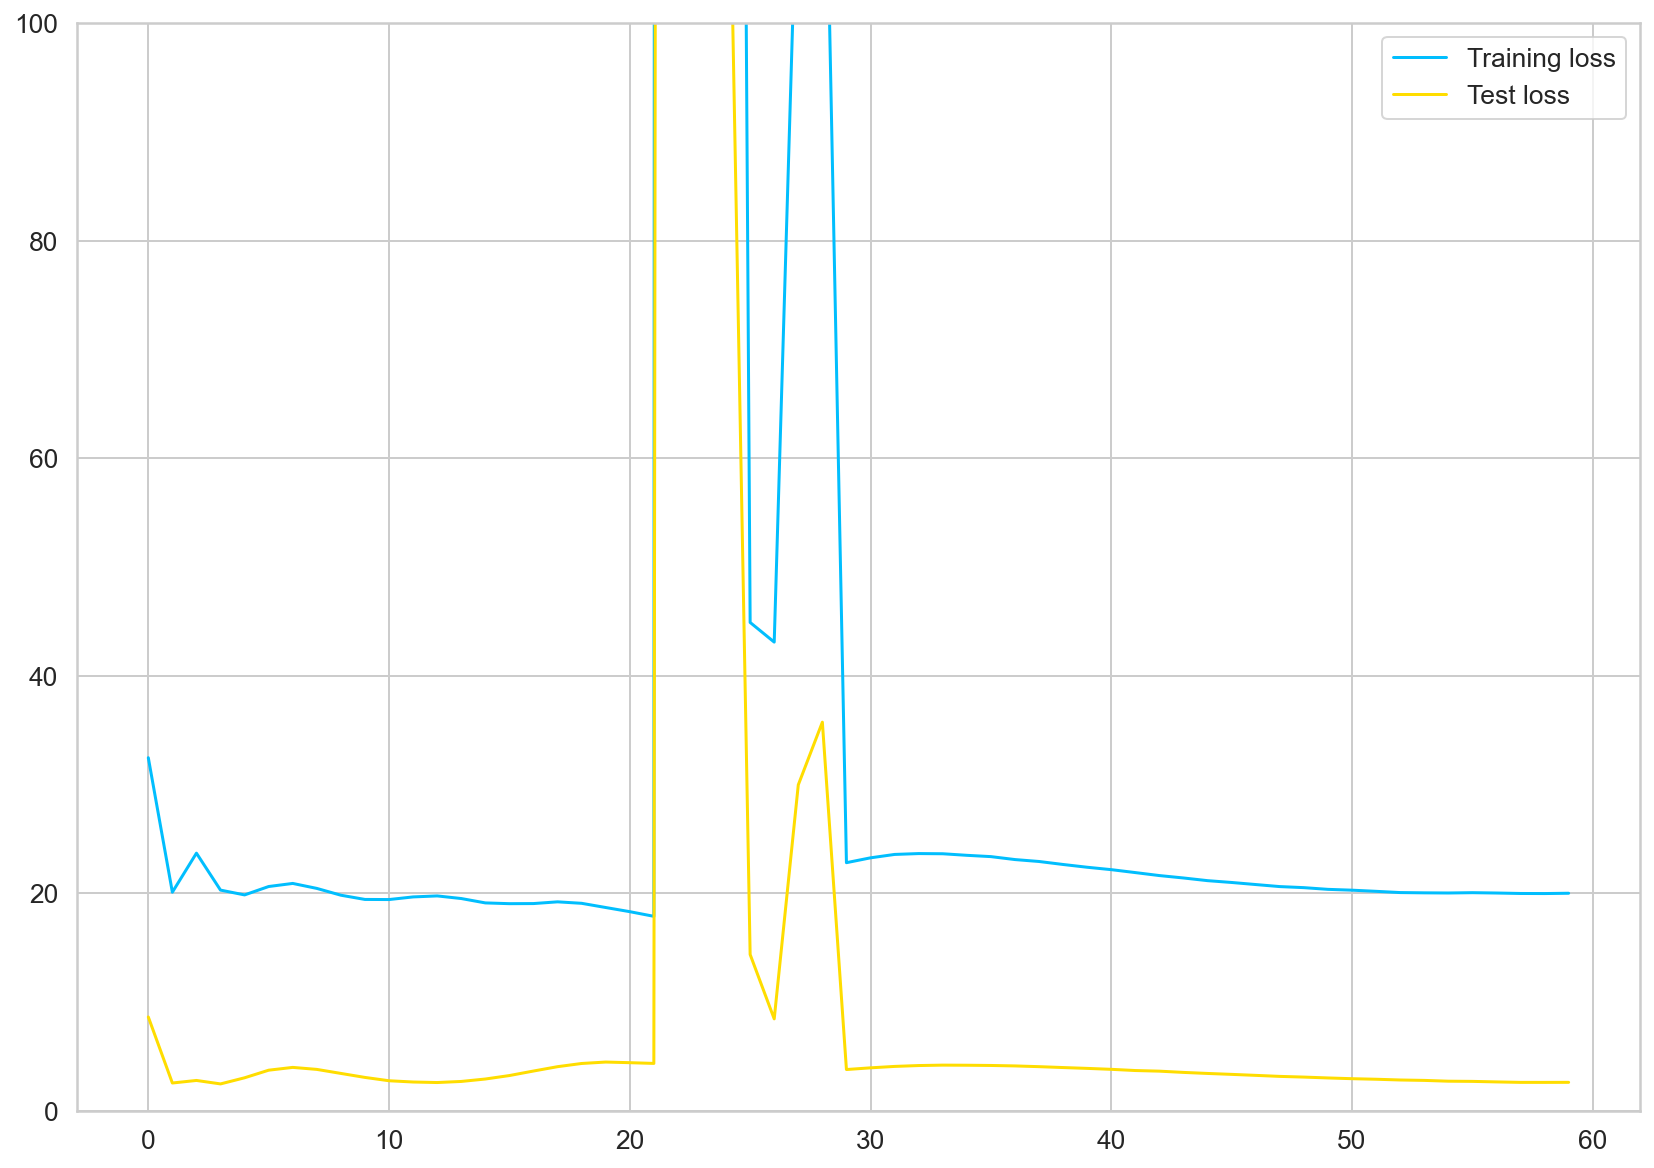

In [24]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 100))
plt.legend();

# Predicting Daily Cases

In [25]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [26]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

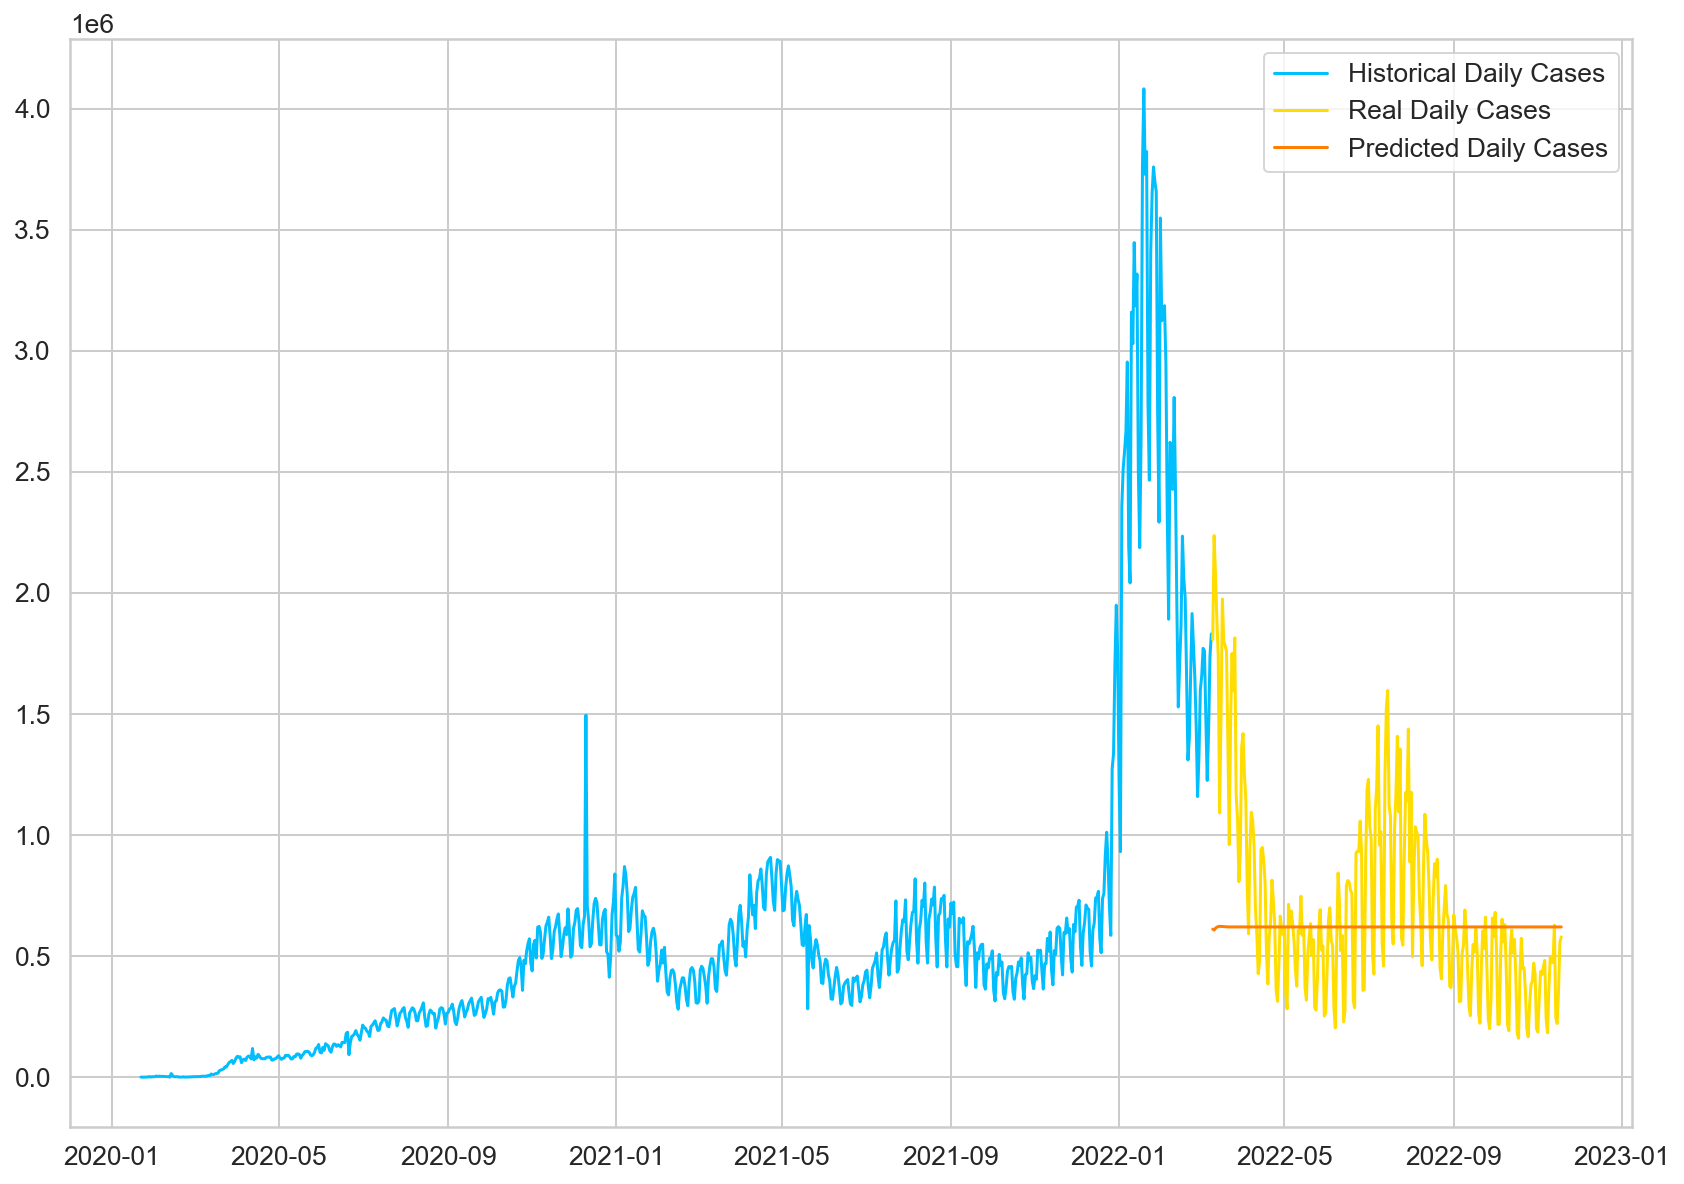

In [27]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

# Using all data for Training

In [28]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(1038, 1)

In [29]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 40.108951568603516
Epoch 10 train loss: 20.193632125854492
Epoch 20 train loss: 19.457103729248047
Epoch 30 train loss: 18.503482818603516
Epoch 40 train loss: 22.298458099365234
Epoch 50 train loss: 19.632349014282227


# Predicting Future Cases

In [30]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [31]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [32]:
daily_cases.index[-1]

Timestamp('2022-11-24 00:00:00')

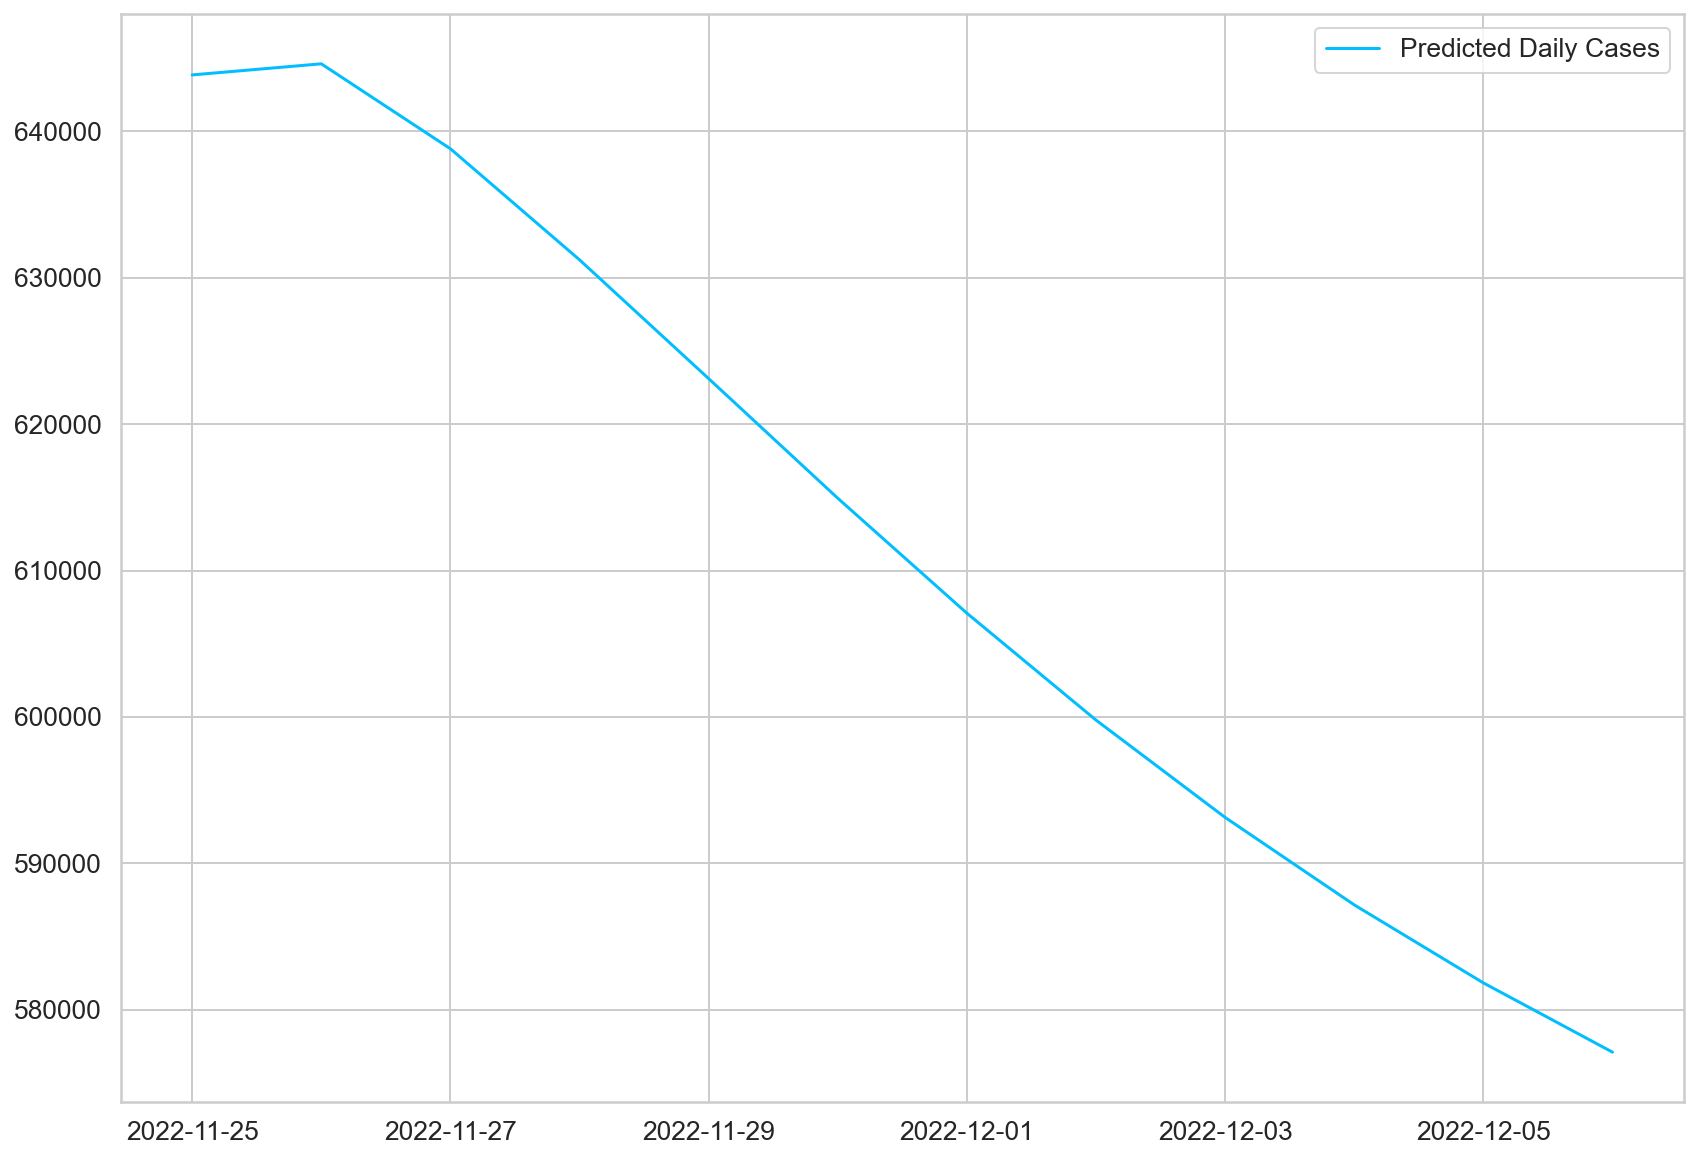

In [33]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

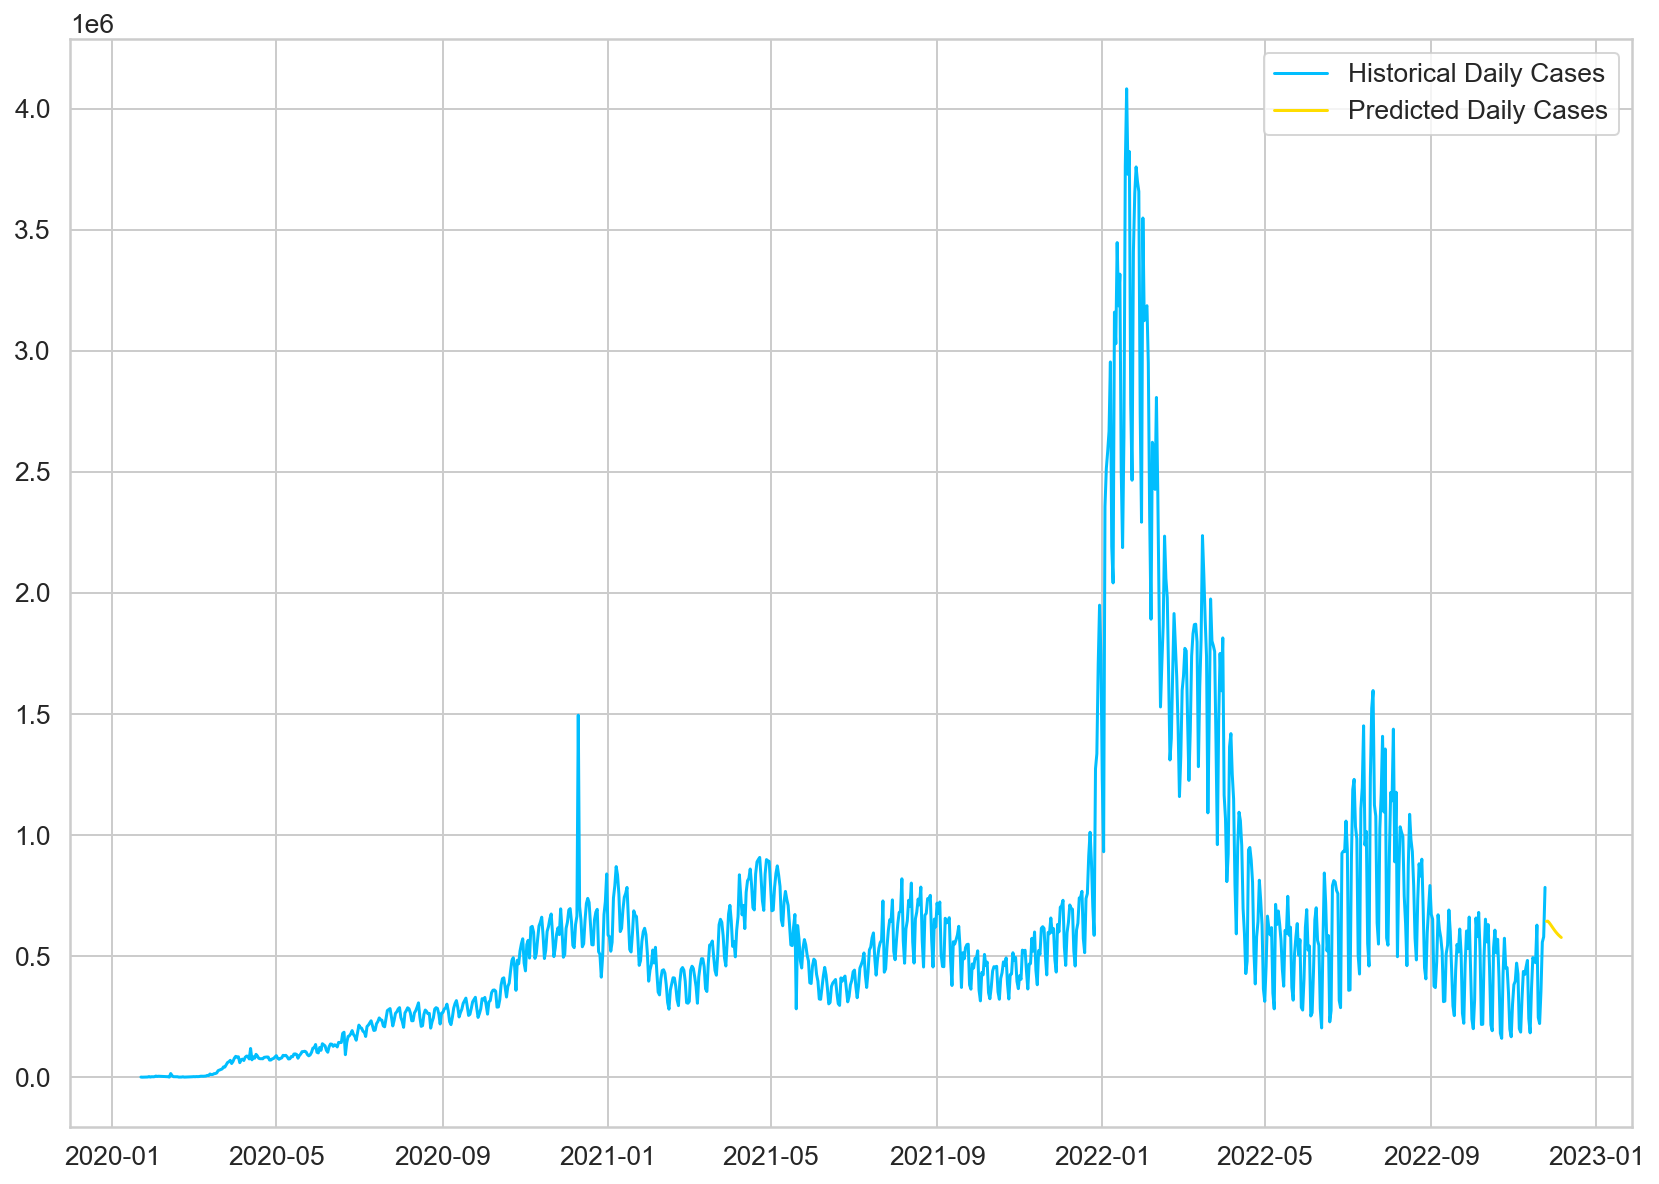

In [34]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

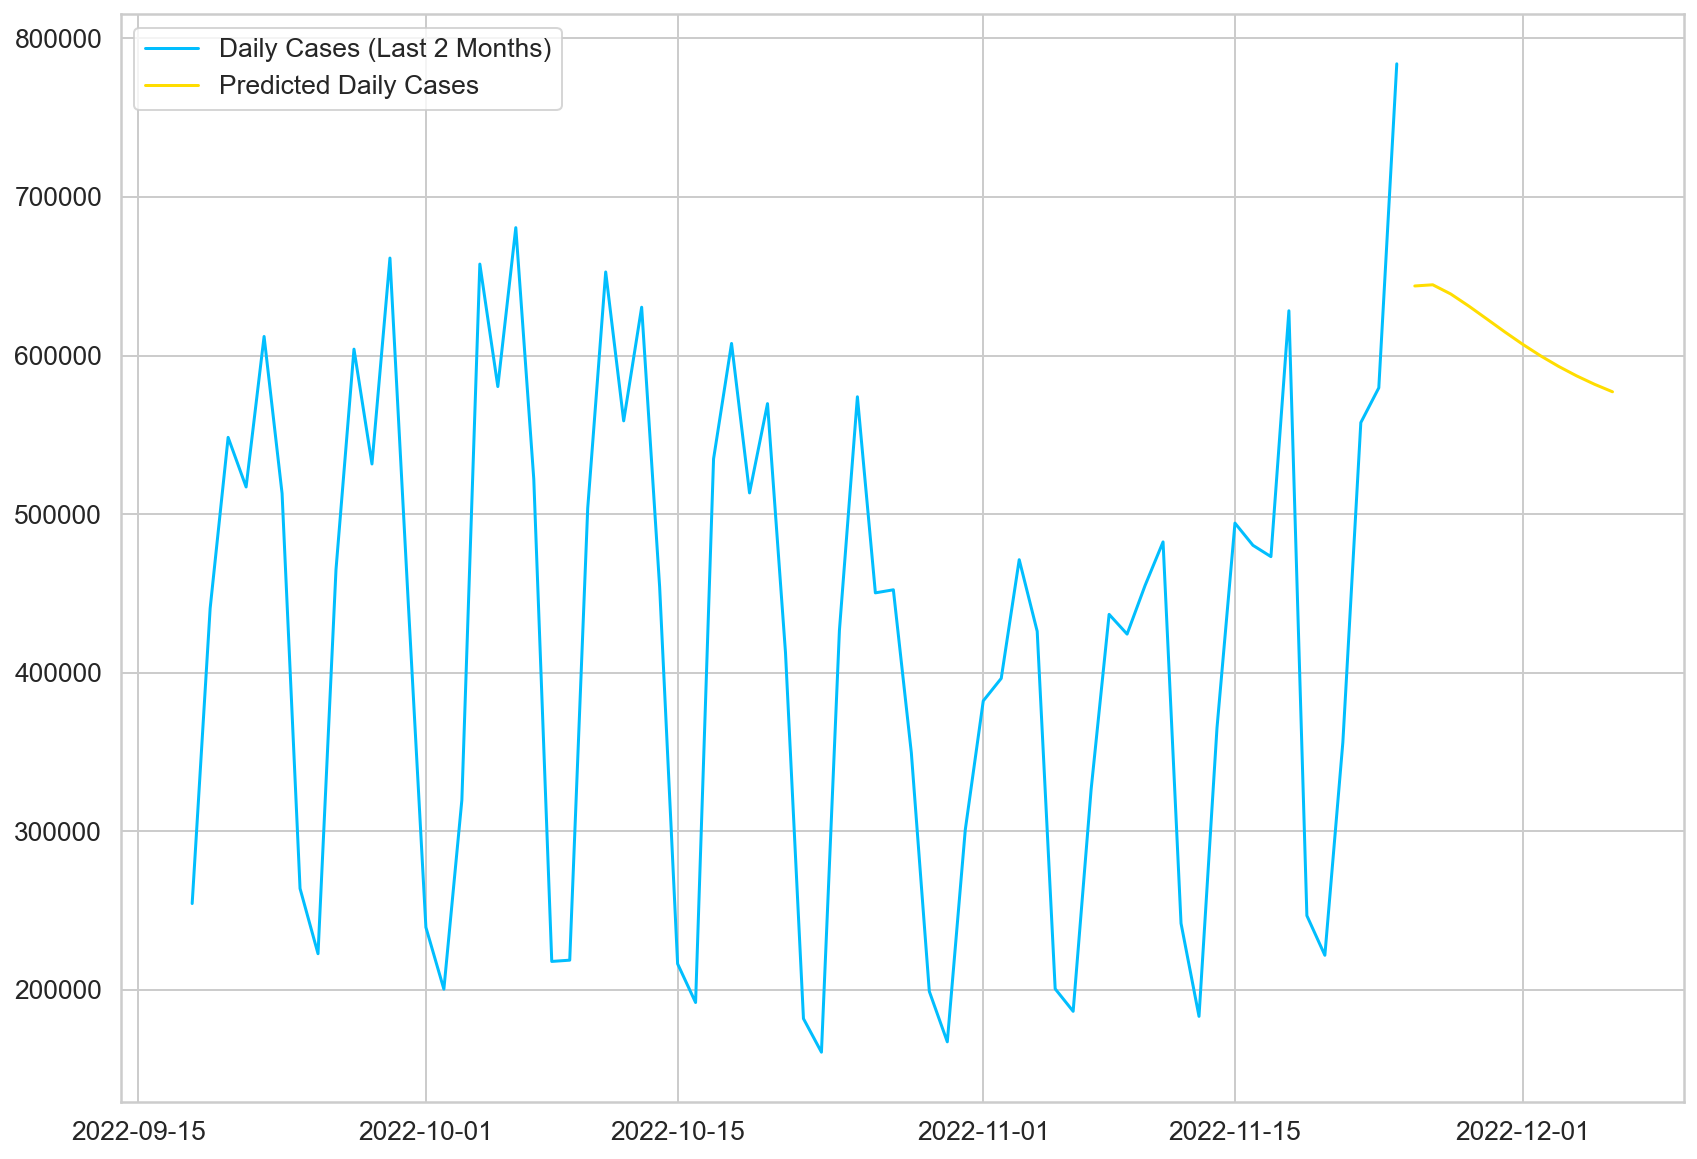

In [35]:
plt.plot(daily_cases[970:], label='Daily Cases (Last 2 Months)')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();